In [1]:
import pandas as pd
import numpy as np
import gzip
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import defaultdict #data colector

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise
from surprise import dump


from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold

  ##CrossValidation
from surprise.model_selection import cross_validate

from surprise import accuracy


  ##Matrix Factorization Algorithms
from surprise import SVD

# TOY DATA/MODEL

In [4]:
ratings_toy = pd.DataFrame({"reviewerID": ['a','a','a','a','a', 'b','b','b','b','c','c','c'],
                        "title":['111', '222', '333', '444','555', '111','222','333','444','111','222','333'],
                        "overall":[1,2,3,4,5,2,3,4,5,3,4,5]})
ratings_toy

,reviewerID,title,overall
0,a,111,1
1,a,222,2
2,a,333,3
3,a,444,4
4,a,555,5
5,b,111,2
6,b,222,3
7,b,333,4
8,b,444,5
9,c,111,3


## Toy Utility (rating) Matrix R

In [5]:
ratings_toy_pivot = ratings_toy.pivot_table(index = 'reviewerID', columns =  'title', values = 'overall')
ratings_toy_pivot

title,111,222,333,444,555
reviewerID,,,,,
a,1.0,2.0,3.0,4.0,5.0
b,2.0,3.0,4.0,5.0,NaN
c,3.0,4.0,5.0,NaN,NaN


#### GLOBAL mean that substitues empty cells in the utility matrix

In [6]:
ratings_toy.mean()

overall    3.416667
dtype: float64

In [159]:
reader = Reader(rating_scale=(1, 5)) #line_format by default order of the fields
data_toy = Dataset.load_from_df(ratings_toy[["reviewerID","title","overall"]], reader=reader)

In [160]:
data_toy.raw_ratings

[('a', '111', 1.0, None),
 ('a', '222', 2.0, None),
 ('a', '333', 3.0, None),
 ('a', '444', 4.0, None),
 ('a', '555', 5.0, None),
 ('b', '111', 2.0, None),
 ('b', '222', 3.0, None),
 ('b', '333', 4.0, None),
 ('b', '444', 5.0, None),
 ('c', '111', 3.0, None),
 ('c', '222', 4.0, None),
 ('c', '333', 5.0, None)]

In [161]:
print(ratings_toy.reviewerID.nunique())
print(ratings_toy.title.nunique())
print(ratings_toy.reviewerID.nunique()*ratings_toy.title.nunique())

3
5
15


## Data (Surprise Class)

In [219]:
trainset_toy = data_toy.build_full_trainset()
testset_yoy = trainset_toy.build_anti_testset()

In [220]:
param_grid = {'n_factors': [5, 10], 'n_epochs': {10,15,20}, 'lr_all': [0.002, 0.005]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv = 3)
gs.fit(data_toy)

In [221]:
print(gs.best_params['rmse'])

{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005}


In [165]:
algo_SVD = SVD(n_factors = 5,
               n_epochs = 20,
               lr_all = 0.005)

algo_SVD.fit(trainset_toy)

In [166]:
predictions_toy = algo_SVD.test(testset_yoy)
predictions_toy

[Prediction(uid='b', iid='555', r_ui=3.4166666666666665, est=3.5770217008859944, details={'was_impossible': False}),
 Prediction(uid='c', iid='444', r_ui=3.4166666666666665, est=3.7958513542078345, details={'was_impossible': False}),
 Prediction(uid='c', iid='555', r_ui=3.4166666666666665, est=3.7410910844909218, details={'was_impossible': False})]

In [167]:
# RMSE should be low as we are biased
accuracy.rmse(predictions_toy, verbose=True)

RMSE: 0.3026


0.30262516261638583

## Function for Recommendstions

In [329]:
#def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):

def get_top_n(predictions, reviewerID, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.reviewerID == (reviewerID)]
    print('User {0} has already rated {1} movies.'.format(reviewerID, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["reviewerID","title","rat_pred"])
    
    preds_df = preds_df[preds_df['reviewerID'] == reviewerID]
          
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.reviewerID == (reviewerID) ].sort_values("overall", ascending = False)
    
    
    return preds_df, hist_usr # pred_usr

### examination

In [330]:
ratings_toy_pivot

title,111,222,333,444,555
reviewerID,,,,,
a,1.0,2.0,3.0,4.0,5.0
b,2.0,3.0,4.0,5.0,NaN
c,3.0,4.0,5.0,NaN,NaN


In [331]:
predictions_toy

[Prediction(uid='b', iid='555', r_ui=3.4166666666666665, est=3.5770217008859944, details={'was_impossible': False}),
 Prediction(uid='c', iid='444', r_ui=3.4166666666666665, est=3.7958513542078345, details={'was_impossible': False}),
 Prediction(uid='c', iid='555', r_ui=3.4166666666666665, est=3.7410910844909218, details={'was_impossible': False})]

### Prediction on toy data

In [332]:
toy_pred, topy_hist =  get_top_n(predictions_toy, reviewerID = 'c', ratings_df = ratings_toy , n = 10)

User c has already rated 3 movies.


In [333]:
toy_pred

,reviewerID,title,rat_pred
1,c,444,3.795851
2,c,555,3.741091


In [28]:
topy_hist

,reviewerID,title,overall
11,c,333,5
10,c,222,4
9,c,111,3


## Amazon Data

In [334]:
data_dir = os.path.join('/Users/jiristodulka/GoogleDrive/GitHub/Netflix_Movie_Filter','data')

In [335]:
ratings = pd.read_csv(data_dir + '/ratings_sample.csv').drop_duplicates(subset=['reviewerID', 'title'])

In [336]:
ratings

,reviewerID,title,overall
0,A2U7DG83EXUSFP,An American Christmas Carol VHS,5.0
1,A2L3Y17SPNJ918,An American Christmas Carol VHS,4.0
2,A340KTL9KUGYB7,An American Christmas Carol VHS,3.0
3,AM87PNTXTKLOI,An American Christmas Carol VHS,4.0
4,AURHUEDIPJ4T9,An American Christmas Carol VHS,5.0
...,...,...,...
296498,A1NSDP9YZXLMDX,Innocence,3.0
296499,A23DFB8IUTIZM0,Verdi: Falstaff,5.0
296500,A2RG7OPDXVQZU2,Terminator Genisys,2.0
296501,AP6KDSZPSP288,Terminator Genisys,3.0


In [337]:
amazon_imbd_titles = pd.read_csv(
    data_dir + '/amazon_unique_title_common_imbd_info.csv').drop_duplicates(subset=['reviewerID', 'title'])

In [338]:
amazon_imbd_titles.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,countries,languages,actors,genre,tagline,description,directors,runtime,imdb_url,votes_int
0,5.0,True,"04 13, 2015",A2OI3HU0KN4118,0005119367,{'Format:': ' DVD'},Shantal N.,Thanks for everything.,Five Stars,1428883200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,True,"04 15, 2014",A385J7MEM932DL,0005119367,{'Format:': ' DVD'},Jim,This one was really interesting! Loved it com...,Bible Story,1397520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,True,"04 27, 2017",AIVTZDMB297BG,0767001311,{'Format:': ' DVD'},Alan Denman,funny,Five Stars,1493251200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,True,"12 2, 2016",AXOX48S8K994V,0767001311,{'Format:': ' DVD'},Amazon Customer,Great series,Four Stars,1480636800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,True,"10 13, 2016",A3J9LLWHZH15HG,0767001311,{'Format:': ' DVD'},JJ,I happen to like Bob Newhart even though he is...,"Well done, amusing series.",1476316800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
ratings

,reviewerID,title,overall
0,A2U7DG83EXUSFP,An American Christmas Carol VHS,5.0
1,A2L3Y17SPNJ918,An American Christmas Carol VHS,4.0
2,A340KTL9KUGYB7,An American Christmas Carol VHS,3.0
3,AM87PNTXTKLOI,An American Christmas Carol VHS,4.0
4,AURHUEDIPJ4T9,An American Christmas Carol VHS,5.0
...,...,...,...
296498,A1NSDP9YZXLMDX,Innocence,3.0
296499,A23DFB8IUTIZM0,Verdi: Falstaff,5.0
296500,A2RG7OPDXVQZU2,Terminator Genisys,2.0
296501,AP6KDSZPSP288,Terminator Genisys,3.0


In [340]:
merged_ratings = pd.merge(ratings, amazon_imbd_titles[['old', 'new']], how = 'inner', left_on='title',  right_on='old' )
merged_ratings.drop_duplicates(inplace = True)

In [341]:
ratings[ratings['title'].isin(amazon_imbd_titles['old'])]

,reviewerID,title,overall
427,AGT9N96H15B15,Steel Magnolias VHS,5.0
428,A81Z2THNUIWS2,Steel Magnolias VHS,5.0
429,A2O9M056X2BK8T,Steel Magnolias VHS,4.0
430,A23A0QXR5ULD9F,Steel Magnolias VHS,5.0
431,A3ANO8MT4P12D8,Steel Magnolias VHS,5.0
...,...,...,...
294689,A31GBCW6YPY9OW,God's Not Dead 2,5.0
294690,AVJCSUZYIRR53,God's Not Dead 2,5.0
295440,AG49D1LO7VTPY,Somewhere in Time,5.0
295441,A28LN6UJ5SJBC7,Somewhere in Time,5.0


In [342]:
merged_ratings['title'] = merged_ratings['new']
merged_ratings = merged_ratings.drop(['old', 'new'], axis = 1)

In [343]:
merged_ratings

,reviewerID,title,overall
0,AGT9N96H15B15,Steel Magnolias,5.0
11,A81Z2THNUIWS2,Steel Magnolias,5.0
22,A2O9M056X2BK8T,Steel Magnolias,4.0
33,A23A0QXR5ULD9F,Steel Magnolias,5.0
44,A3ANO8MT4P12D8,Steel Magnolias,5.0
...,...,...,...
456542,A2MWHPNXYBKQQP,God's Not Dead,5.0
456548,A2HKFMBM1WNE22,God's Not Dead,3.0
456554,A3AL9BPP2PQA3J,God's Not Dead,5.0
456560,A31GBCW6YPY9OW,God's Not Dead,5.0


In [238]:
ratings

,reviewerID,title,overall
0,A2U7DG83EXUSFP,An American Christmas Carol VHS,5.0
1,A2L3Y17SPNJ918,An American Christmas Carol VHS,4.0
2,A340KTL9KUGYB7,An American Christmas Carol VHS,3.0
3,AM87PNTXTKLOI,An American Christmas Carol VHS,4.0
4,AURHUEDIPJ4T9,An American Christmas Carol VHS,5.0
...,...,...,...
296498,A1NSDP9YZXLMDX,Innocence,3.0
296499,A23DFB8IUTIZM0,Verdi: Falstaff,5.0
296500,A2RG7OPDXVQZU2,Terminator Genisys,2.0
296501,AP6KDSZPSP288,Terminator Genisys,3.0


In [344]:
dime = merged_ratings.reviewerID.nunique()*(merged_ratings.title.nunique())
count_ratings = merged_ratings.overall.count()

In [345]:
def utility_matrix_info(ratings):
    dime = ratings.reviewerID.nunique()*(ratings.title.nunique())
    count_ratings = ratings.overall.count()
    print('There are {0}: userss'.format(ratings.reviewerID.nunique()))
    print('There are {0}: movie titles'.format(ratings.title.nunique()))
    print('The utility matrix has: {0} entries'.format(dime))
    print('There are {0}: ratings in the utility matrix'.format(count_ratings))
    print('Sparsity: {0}'.format((1-(count_ratings/dime))*100),'%')

In [346]:
 utility_matrix_info(merged_ratings)

There are 7637: userss
There are 373: movie titles
The utility matrix has: 2848601 entries
There are 27644: ratings in the utility matrix
Sparsity: 99.02955872022793 %


`^^^ We need to subsample !!!!!`

In [347]:
def subsample_utility_matrix(ratings, reviewer_rating_min, title_rating_min):

    ratings['reviewer_rating_count'] = ratings.groupby(
        'reviewerID')['overall'].transform('count')
    ratings['title_rating_count'] = ratings.groupby(
        'title')['overall'].transform('count')
    subsample = ratings[(ratings['reviewer_rating_count'] > reviewer_rating_min) & (
        ratings['title_rating_count'] > title_rating_min)].drop(['reviewer_rating_count', 'title_rating_count'], axis=1)
    utility_matrix_info(subsample)
    return subsample

In [349]:
subsample_ratings = subsample_utility_matrix(merged_ratings, reviewer_rating_min = 5, title_rating_min = 5)
subsample_ratings

There are 1413: userss
There are 373: movie titles
The utility matrix has: 527049 entries
There are 13827: ratings in the utility matrix
Sparsity: 97.37652476335218 %


,reviewerID,title,overall
33,A23A0QXR5ULD9F,Steel Magnolias,5.0
66,A32AKB5NFIAW97,Steel Magnolias,5.0
88,A2LOA2R50C4FN9,Steel Magnolias,4.0
99,A372W1OI7K64AX,Steel Magnolias,5.0
176,A2KQ36MM72JAXP,Steel Magnolias,4.0
...,...,...,...
456416,A2EHSHZF7FEJJG,God's Not Dead,5.0
456458,A1GJ0SYG0RBWAX,God's Not Dead,3.0
456494,A3JL15TG84TRSN,God's Not Dead,5.0
456500,A1V4F0QIO7JSWH,God's Not Dead,5.0


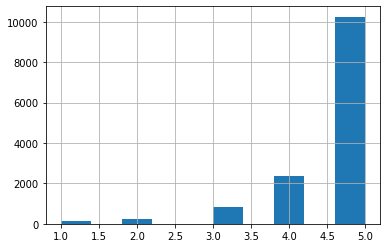

In [113]:
subsample_ratings.overall.hist()
plt.show()

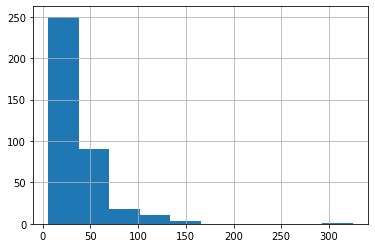

In [114]:
subsample_ratings.title.value_counts().hist()

## MODELING on Subsample

In [350]:
reader = Reader(rating_scale=(1, 5)) #line_format by default order of the fields
data = Dataset.load_from_df(subsample_ratings[["reviewerID","title","overall"]], reader=reader)

In [351]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [352]:
algo_SVD = SVD(n_factors = 5,
               n_epochs = 20,
               lr_all = 0.005)

algo_SVD.fit(trainset)

In [353]:
print(gs.best_estimator['rmse'])
print(gs.best_params['rmse'])

{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005}


In [354]:
#testset = trainset.build_testset()
predictions = algo_SVD.test(testset)
# RMSE should be low as we are biased
accuracy.rmse(predictions, verbose=True)

RMSE: 0.3228


0.3228001966681532

### Double Check: `Is the rating matrix filled now?`

In [195]:
# # doublecheck: does the count of predictions plus counts of rattings add up to 715745 entries inside the matrix?
# assert len(predictions) + subsample_ratings.overall.count() ==  subsample_ratings.reviewerID.nunique()*(subsample_ratings.title.nunique())
# print('Yes, count of rui and rui^head add up to:{0}'.format(subsample_ratings.reviewerID.nunique()*(subsample_ratings.title.nunique())))

In [313]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


kf = KFold(n_splits = 5)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print('Prec.:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Rec.:',sum(rec for rec in recalls.values()) / len(recalls))

Prec.: 0.9054862842892768
Rec.: 0.9281119291717796
Prec.: 0.9036231884057971
Rec.: 0.9214922758401017
Prec.: 0.9061712846347604
Rec.: 0.9278031908384552
Prec.: 0.9145763187429852
Rec.: 0.931131831131831
Prec.: 0.9115438893592996
Rec.: 0.9248908749543803


In [355]:
len(predictions) + 14702 

528170

### Doump the Model

In [366]:
# Compute predictions of the 'original' algorithm.
predictions = algo_SVD.test(testset)

# Dump algorithm and reload it.
file_name = os.path.expanduser('~/dump_file')
dump.dump(file_name, algo=algo_SVD)
_, loaded_algo = dump.load(file_name)

# We now ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(testset)
assert predictions == predictions_loaded_algo
print('Predictions are the same')

Predictions are the same


In [124]:
os.path

<module 'posixpath' from '/Users/jiristodulka/anaconda3/lib/python3.7/posixpath.py'>

`<module 'posixpath' from '/Users/jiristodulka/anaconda3/envs/product_filter/lib/python3.8/posixpath.py'>`

# Predictions and History

In [367]:
subsample_ratings

,reviewerID,title,overall
33,A23A0QXR5ULD9F,Steel Magnolias,5.0
66,A32AKB5NFIAW97,Steel Magnolias,5.0
88,A2LOA2R50C4FN9,Steel Magnolias,4.0
99,A372W1OI7K64AX,Steel Magnolias,5.0
176,A2KQ36MM72JAXP,Steel Magnolias,4.0
...,...,...,...
456416,A2EHSHZF7FEJJG,God's Not Dead,5.0
456458,A1GJ0SYG0RBWAX,God's Not Dead,3.0
456494,A3JL15TG84TRSN,God's Not Dead,5.0
456500,A1V4F0QIO7JSWH,God's Not Dead,5.0


In [368]:
#def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):

def get_top_n(predictions, reviewerID, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.reviewerID == (reviewerID)]
    print('User {0} has already rated {1} movies.'.format(reviewerID, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["reviewerID","title","rat_pred"])
    
    preds_df = preds_df[preds_df['reviewerID'] == reviewerID]
          
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.reviewerID == (reviewerID) ].sort_values("overall", ascending = False)
    
    
    return preds_df, hist_usr # pred_usr

In [361]:
subsample_ratings['reviewerID'].sample()

109567    A38JEMY9AZ9JR2
Name: reviewerID, dtype: object

In [379]:
pred_, hist_ = get_top_n(predictions, reviewerID = 'A38JEMY9AZ9JR2',
                         ratings_df = subsample_ratings, n = 370)

User A38JEMY9AZ9JR2 has already rated 8 movies.


In [377]:
pred_

,reviewerID,title,rat_pred
77791,A38JEMY9AZ9JR2,The Magnificent Seven,4.789489
77792,A38JEMY9AZ9JR2,Secondhand Lions,4.787134
77793,A38JEMY9AZ9JR2,E.T. the Extra-Terrestrial,4.753899
77794,A38JEMY9AZ9JR2,Doctor Zhivago,4.745755
77795,A38JEMY9AZ9JR2,The African Queen,4.737287
...,...,...,...
78152,A38JEMY9AZ9JR2,After Earth,3.891998
78153,A38JEMY9AZ9JR2,Bone Tomahawk,3.762630
78154,A38JEMY9AZ9JR2,The Great Gatsby,3.745799
78155,A38JEMY9AZ9JR2,Cloud Atlas,3.649949


In [371]:
hist_

,reviewerID,title,overall
109567,A38JEMY9AZ9JR2,Under the Tuscan Sun,5.0
152755,A38JEMY9AZ9JR2,New in Town,5.0
241861,A38JEMY9AZ9JR2,The Best Exotic Marigold Hotel,5.0
439905,A38JEMY9AZ9JR2,The Second Best Exotic Marigold Hotel,5.0
441187,A38JEMY9AZ9JR2,The Best Exotic Marigold Hotel,5.0
452395,A38JEMY9AZ9JR2,A Christmas Story,5.0
15195,A38JEMY9AZ9JR2,The First Wives Club,4.0
7676,A38JEMY9AZ9JR2,Pretty Woman,1.0


In [374]:
subsample_ratings.title.nunique()

373

In [338]:
subsample_ratings.drop_duplicates().to_csv(data_dir + '/sampled_titles_baseline.csv', index=False)